In [1]:
import numpy as np
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi import task
from unagi.task import hsc_psf,hsc_cutout,hsc_tricolor
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astroquery.gama import GAMA
import sep

from imcascade import Fitter, ImcascadeResults
from imcascade.psf_fitter import PSFFitter
import imcascade.utils as utils
pdr2 = hsc.Hsc(dr='pdr2',rerun = 'pdr2_wide')

# Get table list from /home/tim/anaconda3/envs/imc/lib/python3.9/site-packages/unagi-0.1.3.dev11-py3.9.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits


To find galaxies for degredation test

In [ ]:
tab = GAMA.query_sql("Select i.ra,i.dec, s.z,s.logmstar from InputCatA as i join StellarMasses as s on i.cataid = s.cataid where s.z between 0.05 and 0.06 and s.logmstar between 10.5 and 10.6")
tab

To find example galaxy

In [ ]:
tab = GAMA.query_sql("Select i.ra,i.dec, s.z,s.logmstar from InputCatA as i join StellarMasses as s on i.cataid = s.cataid where s.z between 0.29 and 0.3 and s.logmstar between 10.4 and 10.5")
tab
ind = 45
examp_coord = SkyCoord(ra = tab[ind]['ra']*u.deg, dec = tab[ind]['DEC']*u.deg)
print (examp_coord)
task.hsc_check_coverage(examp_coord, archive=pdr2, verbose=True)

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


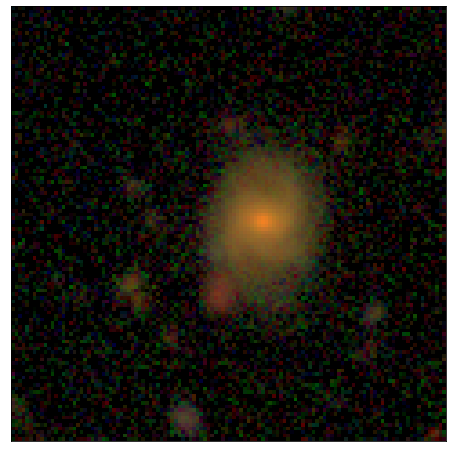

In [2]:
#ra_use,dec_use = 132.26938138, 1.24055408 #log m* ~ 11
ra_use,dec_use = 214.18654393, -0.74002794#log m* ~ 10.5
examp_coord = SkyCoord(ra = ra_use*u.deg, dec = dec_use*u.deg)
s_ang = 10*u.arcsec
cutout_rgb, cutout_wcs = hsc_tricolor(
    examp_coord, cutout_size=s_ang, filters='gri', verbose=True, 
    save_rgb=False, save_img=False, use_saved=False, archive=pdr2)
fig = plt.subplots(figsize=(8,8))
plt.imshow(cutout_rgb, origin='lower')
plt.xticks([])
plt.yticks([])
plt.show()

In [69]:
s_ang = 30*u.arcsec
output_dir = './hsc_data/ex_gal/'
filt_use = 'gri'
cutout = hsc_cutout(examp_coord, cutout_size=s_ang, filters=filt_use, archive = pdr2, dr = 'pdr2',
                         use_saved=False, output_dir=output_dir, verbose=True, variance=True, mask=True, 
                         save_output=True)
psf_model = hsc_psf(examp_coord, filters=filt_use, archive=pdr2, save_output = True,output_dir=output_dir)

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving coadd PSF model in filter: g
# Retrieving coadd PSF model in filter: r
# Retrieving coadd PSF model in filter: i


In [79]:
img = cutout[0][1].data[1:,:].byteswap().newbyteorder()
var = cutout[0][3].data[1:,:].byteswap().newbyteorder()
psf = psf_model[0][0].data.byteswap().newbyteorder()

/mnt/c/Users/timbl/Desktop/files/research/packages/imcascade/imcascade/psf_fitter.py:158: RuntimeWarning: divide by zero encountered in true_divide
  resid = (self.psf_data - mod)/mod
/mnt/c/Users/timbl/Desktop/files/research/packages/imcascade/imcascade/psf_fitter.py:158: RuntimeWarning: invalid value encountered in true_divide
  resid = (self.psf_data - mod)/mod


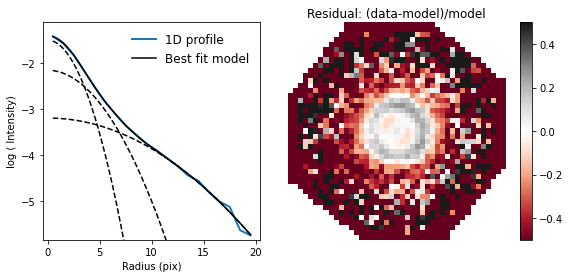

In [80]:
pfitter = PSFFitter(psf)
psf_sig,psf_a, chi2, fig = pfitter.fit_N(3, plot = True)
plt.show()

In [81]:
bkg = sep.Background(img)
obj,seg = sep.extract(img, 2.5, err = np.sqrt(var), segmentation_map = True)

<ipython-input-81-9413cab92bec>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. Use `int` by itself, which is identical in behavior, to silence this warning. If you specifically wanted the numpy scalar type, use `np.int_` here.
  obj,seg = sep.extract(img, 2.5, err = np.sqrt(var), segmentation_map = True)


In [82]:
np.max(obj['flux'])

466.4842834472656

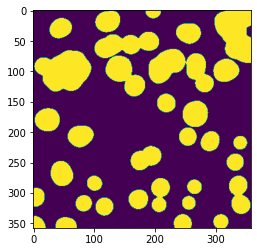

In [83]:
mask = np.copy(seg)
mask[np.where(mask == seg[int(seg.shape[0]/2),int(seg.shape[0]/2)])] = 0
mask[np.where(mask > 0.1)] = 1
mask = utils.expand_mask(mask, radius = 4)
plt.imshow(mask)

In [87]:
img.shape

(358, 358)

In [91]:
sig = utils.asinh_scale(0.75,100, 10)
fitter = Fitter(img,sig, psf_sig,psf_a, weight = 1./var, mask = mask, init_dict = {'re': 10., 'flux':400})

In [92]:
fitter.run_ls_min(ls_kwargs = {'verbose':2})
res = ImcascadeResults(fitter)
res.run_basic_analysis()

2021-02-17 16:52:44,523 - Running least squares minimization


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6177e+05                                    4.77e+05    
       1              2         1.0457e+05      5.72e+04       2.36e+00       6.96e+04    
       2              3         7.9140e+04      2.54e+04       3.41e+00       3.12e+04    
       3              4         5.9098e+04      2.00e+04       3.01e+00       1.74e+05    
       4              5         5.2878e+04      6.22e+03       1.71e+00       1.96e+05    
       5              6         4.8238e+04      4.64e+03       4.57e-01       3.14e+04    
       6              8         4.8133e+04      1.05e+02       4.02e-01       2.87e+04    
       7              9         4.7846e+04      2.87e+02       4.00e-01       4.93e+03    
       8             11         4.7823e+04      2.31e+01       1.83e-01       3.54e+03    
       9             13         4.7812e+04      1.10e+01       8.36e-02       5.53e+02    

2021-02-17 16:56:28,552 - Finished least squares minimization


Could not load - posterier
Could not load - post_method
Could not load - log_file


{'flux': 435.2419156284468,
 'r20': 3.602433695107242,
 'r50': 9.099780345033205,
 'r80': 21.098167961154093,
 'r90': 43.27873975948583,
 'C80_20': 5.856642966061868,
 'C90_50': 4.75602026845714}

In [93]:
posterier = fitter.run_dynesty(method = 'express')

2021-02-17 16:56:28,579 - Running dynesty using the express method
2021-02-17 16:56:28,580 - Setting up Express params
2021-02-17 16:56:28,581 - Parameters to be set for express method:
2021-02-17 16:56:28,583 - 	 Galaxy Center: 181.11,187.74
2021-02-17 16:56:28,585 - 	 Axis Ratio: 1.00000
2021-02-17 16:56:28,587 - 	 PA: 1.35649
iter: 9447 | batch: 0 | bound: 105 | nc: 25 | ncall: 211921 | eff(%):  4.447 | loglstar:   -inf < -47890.584 <    inf | logz: -47912.474 +/-  0.289 | dlogz: 77.733 >  0.010                          /home/tim/anaconda3/envs/imc/lib/python3.9/site-packages/dynesty-1.0.1-py3.9.egg/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 14149 | batch: 0 | bound: 178 | nc: 25 | ncall: 340483 | eff(%):  4.149 | loglstar:   -inf < -47805.429 <    inf | logz: -47834.306 +/-  0.332 | dlogz:  8.251 >  0.010                         /h

KeyboardInterrupt: 

In [ ]:
res = ImcascadeResults(fitter)
res.run_basic_analysis(cutoff = 100, save_results = True, save_file = './hsc_data/ex_gal/asinh10.asdf')

In [ ]:
import corner

In [ ]:
to_plot = np.vstack([res.r50,res.flux,res.posterier[:,-3], res.posterier[:,-2], res.posterier[:,-1]]).transpose()

In [ ]:
to_plot.shape

In [ ]:
corner.corner(to_plot)
plt.show()

In [ ]:
corner.corner(res.posterier[:,4:])
plt.show()

In [ ]:
r = np.linspace(0.5,75, num = 250)
sbp_all = res.calc_sbp(r)

In [ ]:
sbp_all[:,3::100].shape

In [ ]:
plt.plot(r,sbp_all[:,3::100], 'k-', alpha = 0.1)
plt.yscale('log')
plt.show()

In [ ]:
sig

In [ ]:
np.diff(np.log10(res.sig))

In [ ]:
bkg.globalrms / (np.sqrt(np.pi)*700 )